### Binary Classification w/ SVM and Transformer-based Embeddings

**Binary Classification** is a problem of automatically assigning a **label to an unlabeled example**. In ML, this is solved by a **classification learning algorithm** that takes a collection of **labeled examples** as inputs, and produces a **model** that predicts a label given an example. 

This notebook implements such a model-based **supervised learning algorithm** by taking a collection of labeled financial sentences, and training a basic **Support Vector Machine**. 
It then compares the classification accuracy combining said **SVM** with: 
- transformer-based embeddings using [Cohere Embeddings](https://docs.cohere.com/reference/embed);
- transformer-based embeddings using [OpenAI Embeddings](https://platform.openai.com/docs/api-reference/embeddings);
- frequency-based embeddings using [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

##### Embeddings

**Embeddings** transform discrete values, like words or categories, into continuous vectors in a high-dimensional space. When training a classifier, **transformer-based embeddings** offer several advantages:

- **Context**: Unlike traditional embeddings like Word2Vec or GloVe, transformer embeddings are contextual. This means the representation of a word is based on its surrounding context, allowing for the distinction between different senses or meanings of a word based on its use.

- **Pre-trained Knowledge**: Transformer models come pre-trained on vast text corpora. This pre-training captures a wide range of linguistic structures and patterns. In practice, this allows to achieve good results with less data.

- **Sequence Understanding**: Transformers inherently operate over sequences, making them well-suited to capture relationships between words in sentences, unlike bag-of-words (frequency-based) methods.

##### Support Vector Machine

A **Support Vector Machine (SVM)** is a ML model capable of performing (non) linear classification, regression and outlier detection. SVM are well suited for classification of complex but small- or medium-sized datasets.

----

#### 1. Dataset Preparation

In [1]:
%pip install --upgrade cohere datasets openai python-dotenv scikit-learn tqdm --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

from datasets import load_dataset
from dotenv import find_dotenv, load_dotenv
import tqdm as notebook_tqdm


SAMPLE_SIZE = 550

c:\Users\Diego\dev\dcarpintero\notebooks\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The [FinGPT/fingpt-sentiment-cls](https://huggingface.co/datasets/FinGPT/fingpt-sentiment-cls) dataset provides nearly 50k labeled samples for financial sentiment analysis.

In [3]:
ds = load_dataset("FinGPT/fingpt-sentiment-cls", split="train")
ds

Dataset({
    features: ['input', 'output', 'instruction'],
    num_rows: 47557
})

Inspect Dataset, and check the balance of the 'positive' and 'negative' labels:

In [4]:
[[x, y] for x, y in zip(ds['input'], ds['output'])][0:5]

[["Starbucks says the workers violated safety policies while workers said they'd never heard of the policy before and are alleging retaliation.",
  'negative'],
 ['$brcm raises revenue forecast', 'positive'],
 ["Google parent\xa0Alphabet Inc.\xa0reported revenue and earnings that fell short of analysts' expectations, showing the company's search advertising juggernaut was not immune to a slowdown in the digital ad market. The shares fell more than 6%.",
  'negative'],
 ['Here we highlight some top-ranked technology ETFs that investors can consider betting on as a rebound rally is witnessed in tech stocks.',
  'positive'],
 ['$UVXY Put the chum out there at key support then next level down - careful',
  'negative']]

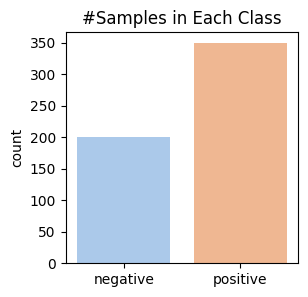

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ["positive", "negative"]
label_names = ds['output'][:SAMPLE_SIZE] 

plt.figure(figsize=(3, 3))
sns.countplot(x=label_names, hue=label_names, palette="pastel")
plt.title("#Samples in Each Class")
plt.show()

----

#### 2. SVM with Transformer-Based Embeddings

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

##### 2.1 SVM with Cohere Embeddings

In [7]:
import cohere

_ = load_dotenv(find_dotenv()) # read local .env file
cohere_api_key = os.environ['COHERE_API_KEY']

In [8]:
X = ds['input'][:SAMPLE_SIZE]
y = ds['output'][:SAMPLE_SIZE]

Vectorize the input sentences using the [Cohere Embeddings](https://docs.cohere.com/reference/embed) model *embed-english-v3.0*. Learn more about this model at https://txt.cohere.com/introducing-embed-v3/ 

In [9]:
co = cohere.Client(cohere_api_key)

X = co.embed(X,
             input_type='classification',
             model="embed-english-v3.0",
             truncate="END").embeddings

In [10]:
# Cohere embeddings dimensions
len(X[0])

1024

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

The SVM is being used within a pipeline that first scales the data using *StandardScaler()*. SVMs are sensitive to the features scales, therefore, scaling input features improves convergence and the performance of the SVM. Moreover, by initializing the SVM with *class_weight='balanced'*, the SVM will automatically adjust weights inversely proportional to class frequencies in the input data. This is helpful when dealing with imbalanced datasets, where one class has many more samples than the other. 

In [12]:
svm_co_clf = make_pipeline(StandardScaler(), SVC(class_weight='balanced')) 
svm_co_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(class_weight='balanced'))])

In [13]:
score_co = svm_co_clf.score(X_test, y_test)

##### 2.2 SVM with OpenAI Embeddings

In [14]:
import openai

_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

In [15]:
X = ds['input'][:SAMPLE_SIZE]
y = ds['output'][:SAMPLE_SIZE]

Vectorize the input sentences using the [OpenAI Embeddings](https://platform.openai.com/docs/api-reference/embeddings) model *text-embedding-ada-002*, which provides 4096 dimensions.

In [16]:
response = openai.Embedding.create(
    input=X,
    model="text-embedding-ada-002"
)

In [17]:
X = [item['embedding'] for item in response['data']]

In [18]:
# OpenAI embeddings dimensions
len(X[0])

1536

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
svm_oai_clf = make_pipeline(StandardScaler(), SVC(class_weight='balanced')) 
svm_oai_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(class_weight='balanced'))])

In [21]:
score_oai = svm_oai_clf.score(X_test, y_test)

----

#### 3. SVM with Frequency-Based Embeddings

**TfidfVectorizer** produces a form of sparse, bag-of-words-based **embeddings**. Specifically, it belongs to the category of *frequency-based embeddings*. The vectors produced by **TfidfVectorizer** are high-dimensional and sparse. 

In practice, the embeddings generated by **TfidfVectorizer** are based on term frequencies in the blocks of text (TF) and the inverse document frequency (IDF) across the entire corpus. Most values in these vectors are zeros because each block of text will typically contain only a small subset of the entire vocabulary.

Note the following considerations:
- **Loss of Word Order**: TF-IDF, being a bag-of-words model, doesn't capture the order of words. For sentences where word order and semantics play a crucial role, this can be limiting.
- **High Dimensionality**: The output vectors can be very high-dimensional, especially if the vocabulary is large. This might be computationally expensive for some models.
- **Semantics**: TF-IDF vectors are based on word frequencies and don't inherently capture semantic meanings of words. So, sentences with similar meanings but different wordings might end up being represented very differently.
- **Long Texts**: For longer documents, TF-IDF often makes more sense because it can highlight the relative importance of words across the document. For very short sentences, the TF (term frequency) aspect might not be as informative, though the IDF (inverse document frequency) can still provide weightings based on the uniqueness of words. 

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(ds['input'][:SAMPLE_SIZE])
y = ds['output'][:SAMPLE_SIZE]

In [24]:
X.shape

(550, 3164)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [26]:
svm_tfidf_clf = make_pipeline(StandardScaler(with_mean=False), SVC(class_weight='balanced')) 
svm_tfidf_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC(class_weight='balanced'))])

In [27]:
score_tfidf = svm_tfidf_clf.score(X_test, y_test)

----

#### 4. Models Performance

In [28]:
print(f"SVM Binary-Text Classification Accuracy ({SAMPLE_SIZE} samples):")
print(f"------------------------------------------------------")
print(f"w/ Cohere 'embed-english-v3.0': {100*score_co:.2f}%")
print(f"w/ OpenAI 'text-embedding-ada-002': {100*score_oai:.2f}%")
print(f"w/ TfidfVectorizer: {100*score_tfidf:.2f}%")

SVM Binary-Text Classification Accuracy (550 samples):
------------------------------------------------------
w/ Cohere 'embed-english-v3.0': 94.93%
w/ OpenAI 'text-embedding-ada-002': 89.13%
w/ TfidfVectorizer: 65.22%


-----